In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import json 
from torch.utils.data import Dataset, DataLoader
from PIL import Image 
import clip 
from torchvision import transforms
from tqdm import tqdm
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append('../..')
import src.utils as utils
%matplotlib inline 

/opt/homebrew/Caskroom/miniforge/base/envs/graphled/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
config = {
    # Data Paths
    'train_path' : '../../data/way_splits/train_data.json',
    'valid_seen_path' : '../../data/way_splits/valSeen_data.json',
    'valid_unseen_path': '../../data/way_splits/valUnseen_data.json',
    'mesh2meters': '../../data/floorplans/pix2meshDistance.json',
    'image_dir': '../../data/floorplans/',

    'device': 'cpu',

    # Hyper Parameters
    'max_floors': 5,

    # Image Parameters 
    'image_size': [3, 224, 224],
    # 'image_size': [3, 700, 1200],
    'original_image_size': [3, 700, 1200],
    
}

In [7]:
# Create Dataset 

class LEDDataset(Dataset):
    def __init__(self, data_path, image_dir, config):

        # Gather train_data from {train/val/test}_data.json
        self.data_path = data_path 
        self.data_file = open(self.data_path)
        self.data = json.load(self.data_file)

        # Extract the mode (train, valSeen, valUnseen) from the data_path 
        self.mode = self.data_path.split('/')[-1][:-5].split('_')[0]

        # Store access to floorplans directory 
        self.image_dir = image_dir 

        # Save the global config 
        self.config = config 

        # mesh2meters
        self.mesh2meters_path = self.config['mesh2meters']
        self.mesh2meters_file = open(self.mesh2meters_path)
        self.mesh2meters = json.load(self.mesh2meters_file)

        # transform required for CLIP 
        def convert_image_to_rgb(image):
            return image.convert("RGB")

        self.preprocess = transforms.Compose([
            # transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            # transforms.CenterCrop(size=(224, 244)),
            convert_image_to_rgb,
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])
        self.preprocess_visualize = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            # transforms.CenterCrop(size=(224, 244)),
            convert_image_to_rgb,
            transforms.ToTensor(),
        ]
        )


    def gather_all_floors(self, index):
        all_maps = torch.zeros(
            self.config['max_floors'],
            self.config["image_size"][0],
            self.config["image_size"][1],
            self.config["image_size"][2],
        )
        all_conversions = torch.zeros(self.config["max_floors"], 1)
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            if "train" in self.mode:
                temp = self.preprocess(img)
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            else:
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            all_conversions[enum, :] = self.mesh2meters[scan_name][floor]["threeMeterRadius"] / 3.0
        return all_maps, all_conversions

    def gather_correct_floor(self, index):
        scan_name = self.data[index]['scanName']
        x, y, floor = self.scale_location(index)
        img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
        
        map = self.preprocess(img)
        conversion = torch.tensor(self.mesh2meters[scan_name][str(floor)]["threeMeterRadius"] / 3.0).float()

        return map, conversion

    def scale_location(self, index):
        if "test" in self.mode:
            return [0, 0, 0]

        floor = self.data[index]['finalLocation']["floor"]
        x, y = self.data[index]['finalLocation']["pixel_coord"]    

        return [int(x * (self.config['image_size'][2]/self.config['original_image_size'][2])), int(x * (self.config['image_size'][1]/self.config['original_image_size'][1])), floor] 
        
    def join_dialog(self, index):
        dialogArray = self.data[index]['dialogArray']
        return " ".join(dialogArray)

    def visualize_data(self, index):
        all_maps = np.zeros((
            self.config['max_floors'],
            self.config["image_size"][1],
            self.config["image_size"][2],
            self.config["image_size"][0],
        )
        )
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        images = []
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            all_maps[enum] = torch.permute(self.preprocess_visualize(img)[:3, :, :], (1, 2, 0)).cpu().numpy()

        # create figure
        fig = plt.figure(figsize=(20, 15))
        
        # setting values to rows and column variables
        rows = 3
        columns = 2
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, 1)
        
        # showing image
        plt.imshow(all_maps[0])
        plt.Circle((100, 100), 50, color='k')
        plt.axis('off')
        plt.title("First")
        
        # Adds a subplot at the 2nd position
        fig.add_subplot(rows, columns, 2)
        
        # showing image
        plt.imshow(all_maps[1])
        plt.axis('off')
        plt.title("Second")
        
        # Adds a subplot at the 3rd position
        fig.add_subplot(rows, columns, 3)
        
        # showing image
        plt.imshow(all_maps[2])
        plt.axis('off')
        plt.title("Third")
        
        # Adds a subplot at the 4th position
        fig.add_subplot(rows, columns, 4)
        
        # showing image
        plt.imshow(all_maps[3])
        plt.axis('off')
        plt.title("Fourth")

        # Adds a subplot at the 4th position
        fig.add_subplot(rows, columns, 5)
        
        # showing image
        plt.imshow(all_maps[4])
        plt.axis('off')
        plt.title("Fourth")

    def visualize_target(self, index):
        all_maps = np.zeros((
            self.config['max_floors'],
            self.config["image_size"][1],
            self.config["image_size"][2],
            self.config["image_size"][0],
        )
        )
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        images = []
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            all_maps[enum] = torch.permute(self.preprocess_visualize(img), (1, 2, 0)).cpu().numpy()
        
        x, y, floor = self.scale_location(index)
        tensor  = all_maps[floor]       
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(tensor)
        
        circ = plt.Circle((x,y),10, color='red')
        ax.add_patch(circ)
        print(self.join_dialog(index))
        # Show the image
        plt.show()


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        target_x, target_y, target_floor = self.scale_location(index)
        maps, conversions = self.gather_correct_floor(index)
        dialog = clip.tokenize(self.join_dialog(index), truncate=True)

        return {
            'target_x': target_x,
            'target_y': target_y,
            'targets': torch.tensor([target_x, target_y]).float(),
            'target_floors': torch.tensor(int(target_floor)).float(),
            'maps': maps,
            'conversions': conversions,
            'dialogs': dialog
        }
             

In [8]:
train_dataset = LEDDataset(config['train_path'], config['image_dir'], config)
valid_seen_dataset = LEDDataset(config['valid_seen_path'], config['image_dir'], config)
valid_unseen_dataset = LEDDataset(config['valid_unseen_path'], config['image_dir'], config)

What do you see? Where are you? I am on a landing of a staircase. In the room is a pool table and fireplace with a high back pink chair near the fireplace. What shape is the pool? It's a pool table. Under the pool table is a floral/patterned rug. There is also a white couch on the other side of the room under a window. Is it a round table that is placed on the rug? No. It's a billiard/pool table on the rug. There is a large plant next to the door. I'm on the landing of the staircase.


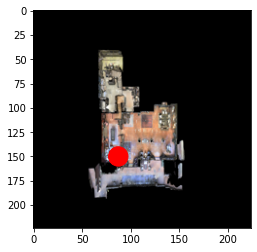

In [10]:
train_dataset.visualize_target(2)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16)

for d in train_loader:
    print(d['maps'].size())
    break

torch.Size([16, 3, 700, 1200])


In [16]:
class CLIPLocator(nn.Module):
    def __init__(self, config):
        super(CLIPLocator, self).__init__()
        self.CLIP, _ = clip.load("RN50")
        self.config = config

        self.dropout = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, 1024)
        self.regressionLinear = nn.Linear(1024, 2)
        # self.floorClassificationLinear = nn.Linear(1024, 5)

    def forward(self, map, dialog):
        image_enc = self.CLIP.encode_image(map)
        text_enc = self.CLIP.encode_text(dialog)
        enc = torch.cat((image_enc, text_enc), dim=-1)
        dropoutOut = self.dropout(enc)
        linear1Out = F.relu(self.linear1(dropoutOut))
        regressionOut = self.regressionLinear(linear1Out)
        # floorclassificationOut = self.floorClassificationLinear(linear1Out)

        return regressionOut # , floorclassificationOut 

In [17]:
cli = CLIPLocator(config)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=6)

In [20]:
for d in train_loader:
    out = cli(d['maps'], d['dialogs'])
    break

RuntimeError: The size of tensor a (778) must match the size of tensor b (50) at non-singleton dimension 0

In [ ]:
def train(train_loader, model, criterion, optimizer, scheduler, device, config):
    # Training 
    for idx, data in enumerate(tqdm(train_loader)):
        
        model.train()
        maps = data['maps'].to(device)
        conversations = data['dialogs']
        targets = data['targets']

        optimizer.zero_grad()
        preds = model(maps, conversations) 
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

def validate(valid_loader, model, criterion, device, config):
    # Validation 
    with torch.no_grad():
        for idx, data in enumerate(tqdm(valid_loader)):
            model.eval()
            maps = data['maps'].to(device)
            conversations = data['dialogs']
            targets = data['targets']

            preds = model(maps, conversations) 
            loss = criterion(preds, targets)

In [51]:
loc = CLIPLocator(config)

In [52]:
def main():

    # Load Data 


    # Define model, loss and optimizer 
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(loc.parameters())
    scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')

    # Run train and validation loop 


    # Run Test 


    # Save results 